<a href="https://colab.research.google.com/github/kpetridis24/computational-intelligence/blob/main/rbf_nn_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression with RBF Neural Network

### RBF NN Regressor

Install custom RBF layer repository and tex-related packages for plotting

In [17]:
# !git clone https://github.com/kpetridis24/rbf_keras.git 
# %pip install -q -U keras-tuner
# %pip install --upgrade pip
# %pip install tensorflow
# %pip install cm-super 
# %pip install latex 
# %pip install texlive texlive-latex-extra texlive-fonts-recommended dvipng 
# %pip install seaborn
# %pip install matplotlib
# %pip install sklearn
# %pip install numpy

**!ATTENTION!** An identation error might occur when cloning the RBF library. To tackle it:
- Go inside the **rbf_keras/rbflayer.py** file and apply proper identation in lines **20-27** (Just select them and press a tab).

Import useful modules

In [18]:
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from rbf_keras import kmeans_initializer
from rbf_keras import rbflayer
import keras_tuner as kt

Load the boston dataset

In [19]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

Take a peek at the dataset

In [20]:
pd.DataFrame(data).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Check for **missing** or **categorical** values so we can handle them appropriately during training

In [21]:
pd.DataFrame(data).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       506 non-null    float64
 1   1       506 non-null    float64
 2   2       506 non-null    float64
 3   3       506 non-null    float64
 4   4       506 non-null    float64
 5   5       506 non-null    float64
 6   6       506 non-null    float64
 7   7       506 non-null    float64
 8   8       506 non-null    float64
 9   9       506 non-null    float64
 10  10      506 non-null    float64
 11  11      506 non-null    float64
 12  12      506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


Check statistical metrics of the dataset to see if any normalization would be convenient

In [22]:
pd.DataFrame(data).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Illustrate the correlation between the variables

<AxesSubplot:>

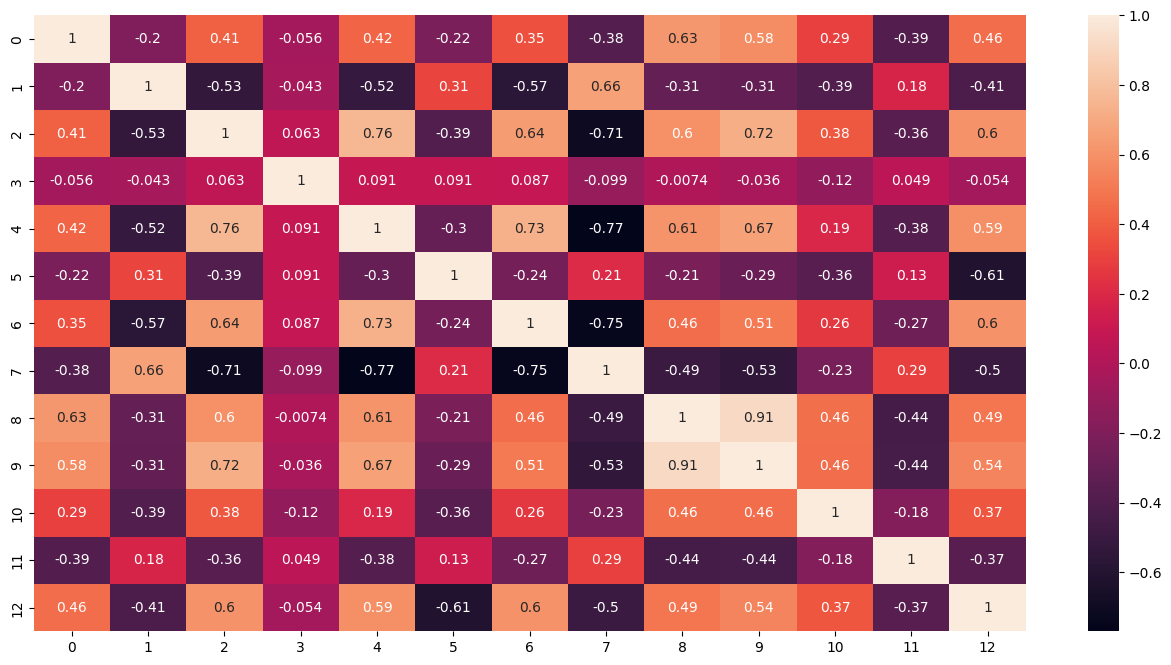

In [23]:
plt.figure(figsize=(16, 8))
sn.heatmap(pd.DataFrame(data).corr(), annot=True)

**Normalize** the dataset, to boost training accuracy. The issue with having parameters in totally different ranges is related to the optimization part of learning. Specifically, a variable in the range [0-1] will require a small value for the *learning rate* to converge, while a variable in the range [$10^3-10^4$] will require a significantly larger value. If we don't normalize, a small learning rate will result in extremely slow convergence of the large variable. A large one on the other hand will cause instability at the small variable.

In [24]:
preprocessing.scale(data, copy=False, axis=0)
pd.DataFrame(data).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,506.000000,5.060000e+02,5.060000e+02,5.060000e+02
mean,-1.123388e-16,7.898820e-17,2.106352e-16,-3.510587e-17,-1.965929e-16,-1.088282e-16,-1.474446e-16,-8.425408e-17,-1.123388e-16,0.000000,-4.212704e-16,-7.442444e-16,-3.089316e-16
std,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990,1.000990e+00,1.000990e+00,1.000990e+00
min,-4.197819e-01,-4.877224e-01,-1.557842e+00,-2.725986e-01,-1.465882e+00,-3.880249e+00,-2.335437e+00,-1.267069e+00,-9.828429e-01,-1.313990,-2.707379e+00,-3.907193e+00,-1.531127e+00
25%,-4.109696e-01,-4.877224e-01,-8.676906e-01,-2.725986e-01,-9.130288e-01,-5.686303e-01,-8.374480e-01,-8.056878e-01,-6.379618e-01,-0.767576,-4.880391e-01,2.050715e-01,-7.994200e-01
50%,-3.906665e-01,-4.877224e-01,-2.110985e-01,-2.725986e-01,-1.442174e-01,-1.084655e-01,3.173816e-01,-2.793234e-01,-5.230014e-01,-0.464673,2.748590e-01,3.811865e-01,-1.812536e-01
75%,7.396560e-03,4.877224e-02,1.015999e+00,-2.725986e-01,5.986790e-01,4.827678e-01,9.067981e-01,6.623709e-01,1.661245e+00,1.530926,8.065758e-01,4.336510e-01,6.030188e-01
max,9.933931e+00,3.804234e+00,2.422565e+00,3.668398e+00,2.732346e+00,3.555044e+00,1.117494e+00,3.960518e+00,1.661245e+00,1.798194,1.638828e+00,4.410519e-01,3.548771e+00


Split the dataset into **train, test, validation** sets as **60%-25%-15%**

In [25]:
data = pd.DataFrame(data)
target = pd.DataFrame(target)

(
    X_train, 
    X_test, 
    y_train, 
    y_test
 ) = train_test_split(
        data, 
        target, 
        test_size=0.25
    )

(
    X_train, 
    X_val, 
    y_train, 
    y_val
 ) = train_test_split(
        X_train, 
        y_train, 
        test_size=0.26
    )
 
N = len(data)

Create the **RBF Neural Network**

In [26]:
from tensorflow.python.ops.init_ops_v2 import Initializer
from keras import backend as K
import math

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))


models = {0.1: None, 0.5: None, 0.9: None}

for percentage in [0.1, 0.5, 0.9]:
    custom_layer = rbflayer.RBFLayer(
                        int(percentage * N),
                        initializer=kmeans_initializer.InitCentersKMeans(data),
                        betas=1.0,
                        input_shape=((13, 1))
                    )

    model = keras.models.Sequential()
    model.add(custom_layer)
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(1, activation="relu"))

    num_of_epochs = 100
    learning_rate = 0.001

    model.compile(
        loss="MeanSquaredError",
        optimizer=keras.optimizers.SGD(
            learning_rate=learning_rate
        ),
        metrics=[
            "MeanSquaredError", 
            coeff_determination
        ]
    )

    models[percentage] = model

**Train** the RBF Neural Network

In [27]:
histories = {0.1: None, 0.5: None, 0.9: None}
num_of_epochs = 100

for perc, model in models.items():
    his = model.fit(
        X_train, 
        y_train, 
        epochs=num_of_epochs, 
        batch_size=32, 
        validation_data=(X_val, y_val), 
        verbose=0
    )
    histories[perc] = his

Plot model $R^2$ and Root Mean Squared Error 
We have three models using **(10%, 50%, 90%)$\times N_{samples}$** number of RBF neurons respectively

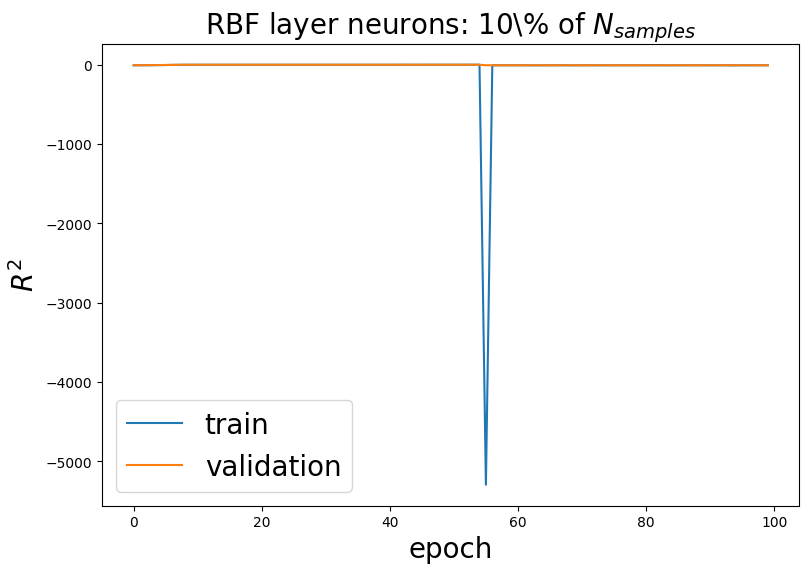

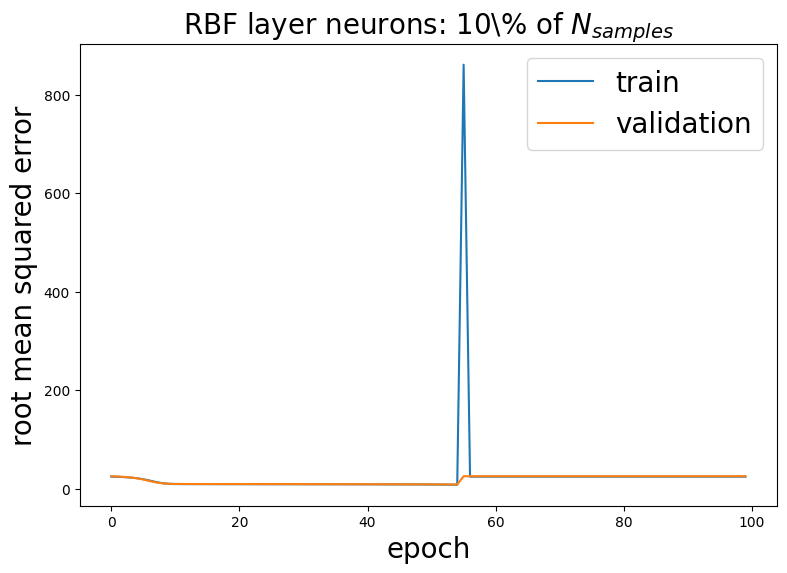

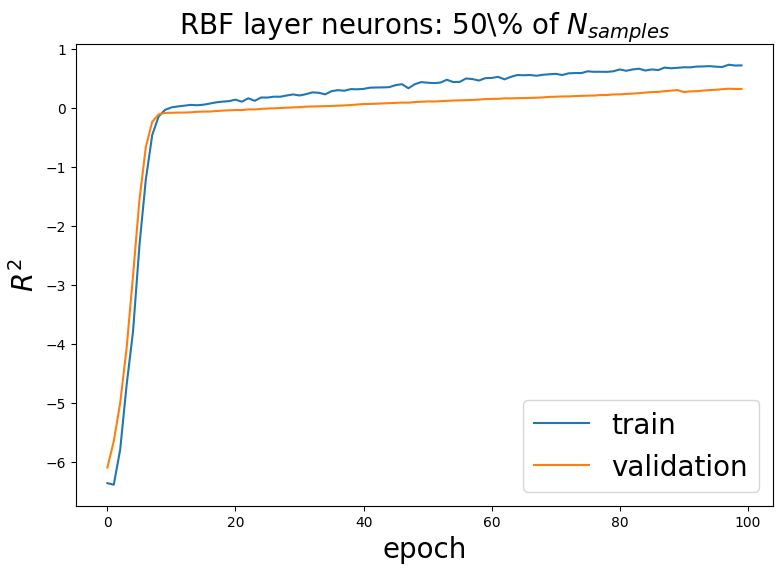

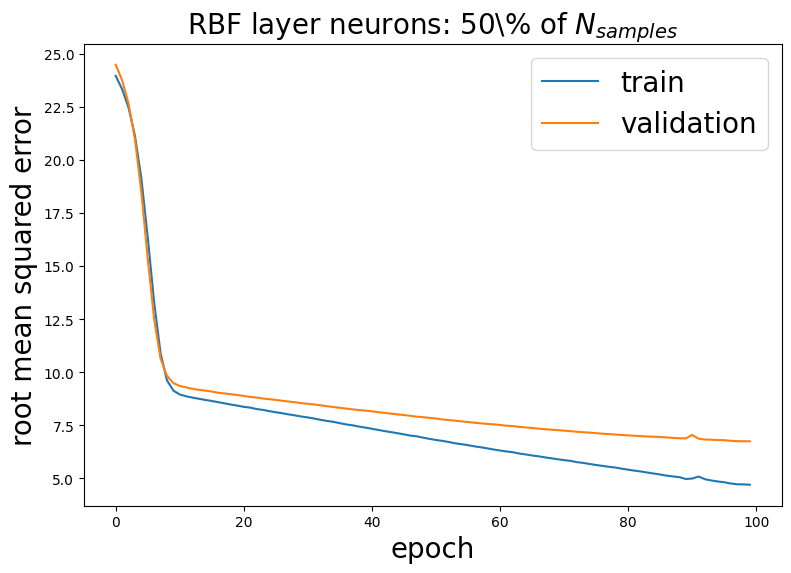

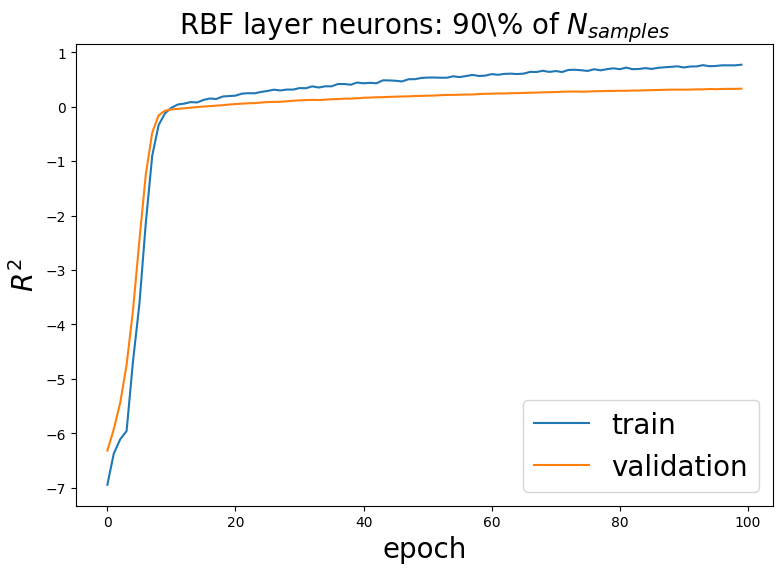

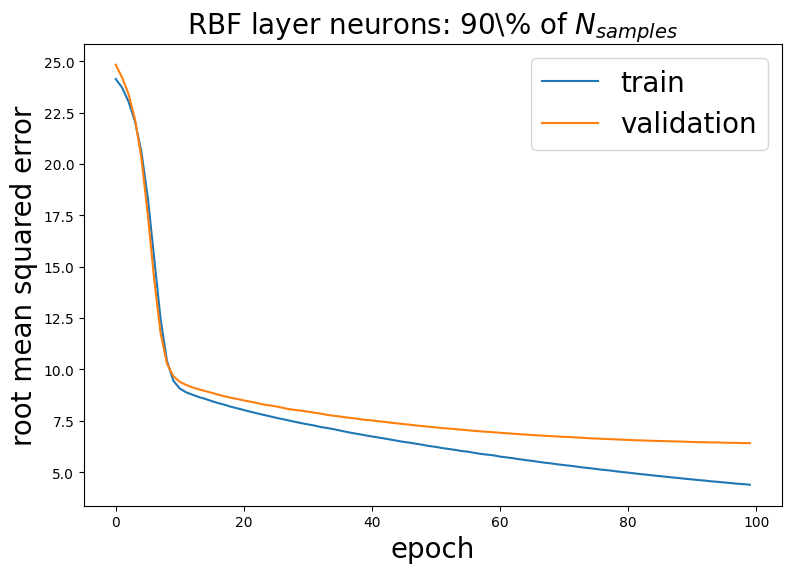

In [28]:
plt.rcParams['text.usetex'] = False

for perc, his in histories.items():
    plt.figure(figsize=(9, 6))
    plt.plot(his.history['coeff_determination'])
    plt.plot(his.history['val_coeff_determination'])
    plt.title(
        'RBF layer neurons: '+ str(int(perc * 100)) + '\% of $N_{samples}$', 
        fontsize=20
    )
    plt.ylabel('$R^2$', fontsize=20)
    plt.xlabel('epoch', fontsize=20)
    plt.legend(['train', 'validation'], prop={'size': 20})
    plt.show()

    plt.figure(figsize=(9, 6))
    plt.plot([math.sqrt(mse) for mse in his.history['mean_squared_error']])
    plt.plot([math.sqrt(mse) for mse in his.history['val_mean_squared_error']])
    plt.title(
        'RBF layer neurons: '+ str(int(perc * 100)) + '\% of $N_{samples}$', 
        fontsize=20
    )
    plt.ylabel('root mean squared error', fontsize=20)
    plt.xlabel('epoch', fontsize=20)
    plt.legend(['train', 'validation'], prop={'size': 20})
    plt.show()


### Fine Tuning of the RBF Regressor

Build the **Tuner**

In [29]:
def build_model(hp):
    hp_rbf_neurons = hp.Choice(
        'rbf neurons', 
        values=[
            int(n) 
            for n in [
                0.05 * N,
                0.15 * N,
                0.30 * N,
                0.50 * N
            ]
        ]
    )
    
    hp_hidden_neurons = hp.Choice(
        'hidden neurons',
        values=[
            32,
            64,
            128,
            256
        ]
    )

    hp_dropout_p = hp.Choice(
        'dropout',
        values=[
            0.2,
            0.35,
            0.5
        ]
    )

    custom_layer = rbflayer.RBFLayer(
                        hp_rbf_neurons,
                        initializer=kmeans_initializer.InitCentersKMeans(data),
                        betas=1.0,
                        input_shape=((13, 1))
                    )
    
    model = keras.models.Sequential()
    model.add(custom_layer)
    model.add(keras.layers.Dense(hp_hidden_neurons, activation="relu"))
    model.add(keras.layers.Dropout(hp_dropout_p, seed=42))
    model.add(keras.layers.Dense(1, activation="relu"))

    num_of_epochs = 100
    learning_rate = 0.001

    model.compile(
        loss="MeanSquaredError",
        optimizer=keras.optimizers.SGD(
            learning_rate=learning_rate, 
            decay=learning_rate / num_of_epochs,
            momentum=0.7, 
        ),
        metrics=[
            "MeanSquaredError", 
            coeff_determination
        ]
    )

    return model

Perform exhaustive search for the  **Optimal Hyperparameters**

In [30]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=50,
    overwrite=True
)

tuner.search(
    X_train, 
    y_train, 
    epochs=num_of_epochs, 
    validation_data=(X_val, y_val)
)

Trial 29 Complete [00h 00m 13s]
val_loss: 37.14750671386719

Best val_loss So Far: 35.54623794555664
Total elapsed time: 00h 05m 53s
INFO:tensorflow:Oracle triggered exit


Print the **optimal hyperparameters**

In [31]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best parameters are:
RBF neurons: {best_hps.get('rbf neurons')} 
Hidden neurons: {best_hps.get('hidden neurons')}
Dropout p: {best_hps.get('dropout')}
""")


The best parameters are:
RBF neurons: 253 
Hidden neurons: 128
Dropout p: 0.2



In [32]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer (RBFLayer)        (None, 253)               3542      
                                                                 
 dense (Dense)               (None, 128)               32512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36,183
Trainable params: 36,183
Non-trainable params: 0
_________________________________________________________________


Use model to obtain predictions on test set and evaluate

In [33]:
train_results = best_model.evaluate(X_train, y_train)
test_result = best_model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 2ms/step - loss: 36.4256 - mean_squared_error: 36.4256 - coeff_determination: 0.5996
